### Importing the Dataset

In [ ]:
import numpy as np
import pandas as pd
import keras

posts = pd.read_csv("../data/Suicide_Detection.csv")
posts.drop(["Unnamed: 0"], axis=1, inplace=True)
posts[["class"]] = (posts[["class"]] == "suicide").astype("int16")

2024-07-08 21:24:56.941170: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-08 21:24:56.948197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 21:24:56.958416: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 21:24:56.958434: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-08 21:24:56.965092: I tensorflow/core/platform/cpu_feature_gua

In [2]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

2024-07-08 21:24:58.541591: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-08 21:24:58.560777: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-08 21:24:58.560868: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Exploring the Dataset

In [3]:
posts.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,Am I weird I don't get affected by compliments...,0
2,Finally 2020 is almost over... So I can never ...,0
3,i need helpjust help me im crying so hard,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",1


In [4]:
posts.describe()

,class
count,232074.000000
mean,0.500000
std,0.500001
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


### Splitting the Dataset

In [5]:
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(posts, test_size=0.1, random_state=42)

#### Analyzing the Dataset

In [6]:
posts = strat_train_set.copy()
posts.head()

,text,class
103752,I am going to kill myself soonI don't know whe...,1
208014,Using this sub as a diary day 68 Today was gre...,0
220765,What else are you supposed to do?I've got a se...,1
116840,Hey you. Yes you I need your help to get this ...,0
149067,non trans gender dysphoria be like menstruatio...,0


In [7]:
post_lengths = [len(post.split()) for post in posts["text"]]

In [8]:
post_lengths[:10]

[98, 58, 273, 54, 109, 10, 166, 103, 43, 190]

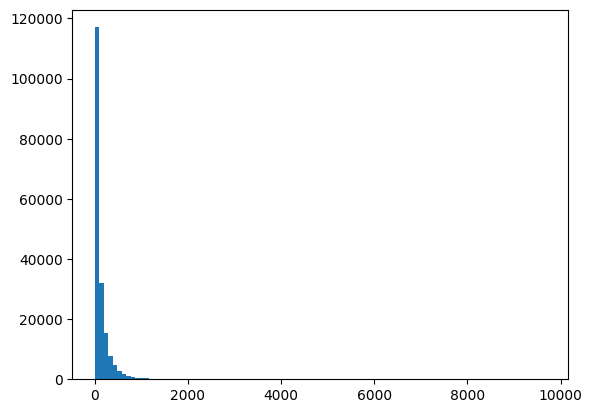

In [9]:
import matplotlib.pyplot as plt

plt.hist(post_lengths, bins=100)
plt.show()

### Building the Classifier

#### Spliting the dataset (again)

In [47]:
strat_train_set, strat_val_set = train_test_split(posts, test_size=1/9, random_state=1)

strat_train_set[:5]

,text,class
157652,I’m sick of it Stop saying neither when asked ...,0
142318,I finally realized how much of an asshole my d...,0
153812,"my cat is sleeping on me, he's literally the c...",0
230100,Why can't I change my bio I need to change my ...,0
24457,If it wasn't for music I would of killed mysel...,1


#### Tokenizing the posts

In [48]:
import spacy
spacy.prefer_gpu()

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp.pipe_names

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']

In [49]:
doc = nlp('I was reading the paper.')
print([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

['read', 'paper']


In [54]:
def preprocess_set(set):
    texts = set.copy()['text']
    labels = set.copy()['class']
    texts = [' '.join(text.split()[:500]) for text in texts]

    docs = (doc for doc in (nlp.pipe(texts)))
    processed_texts = []
    for doc in docs:
        lemmas = [token.lemma_ for token in doc if not token.is_punct]
        processed_texts.append(' '.join(lemmas))
    
    return processed_texts, labels

In [55]:
processed_texts, labels = preprocess_set(strat_train_set)

In [56]:
processed_val_texts, val_labels = preprocess_set(strat_val_set)

#### Creating the Tokenizer

In [57]:
from keras_preprocessing.text import Tokenizer       # type: ignore

tokenizer = Tokenizer(num_words=3000, oov_token='<UNK>')
tokenizer.fit_on_texts(processed_texts)

In [58]:
sequences = tokenizer.texts_to_sequences(processed_texts)

In [59]:
sequence_lengths = [len(sequence) for sequence in sequences if len(sequence) < 1000]

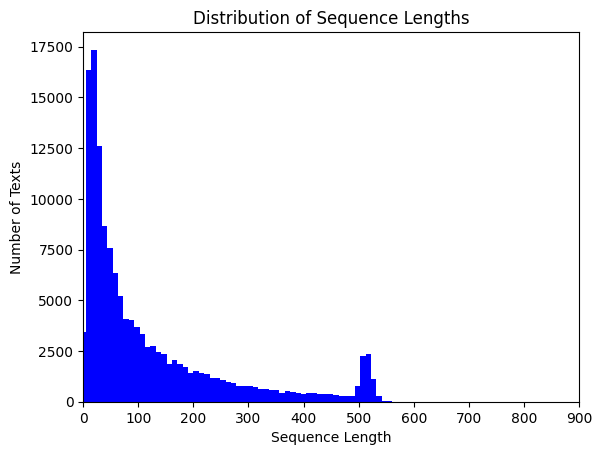

In [60]:
plt.hist(sequence_lengths, bins=100, color='blue', align='left')
plt.xlabel('Sequence Length')
plt.ylabel('Number of Texts')
plt.title('Distribution of Sequence Lengths')
plt.xlim(0, 200)
plt.xticks(range(0, max(sequence_lengths) + 1, 100))
plt.show()

In [61]:
from keras.preprocessing.sequence import pad_sequences

max_len=200

def get_sequences(tokenizer, texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=max_len)
    return padded

padded_train_seq = get_sequences(tokenizer, processed_texts)
train_labels = np.array(labels)

In [62]:
word_index = tokenizer.word_index

sorted(word_index.items(), key=lambda x: x[1])[:10]

[('<UNK>', 1),
 ('i', 2),
 ('be', 3),
 ('to', 4),
 ('and', 5),
 ('the', 6),
 ('not', 7),
 ('a', 8),
 ('my', 9),
 ('do', 10)]

#### Creating the model

In [63]:
Sequential = keras.models.Sequential

model = Sequential([
        keras.layers.Embedding(1000, 16),
    keras.layers.Bidirectional(keras.layers.LSTM(20, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(20)),
    keras.layers.Dense(2, activation='sigmoid')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [24]:
padded_train_seq

array([[  2,  56, 330, ...,   0,   0,   0],
       [  2, 283, 337, ...,   2,   3,  20],
       [  9, 726,   3, ...,   0,   0,   0],
       ...,
       [218, 180,  15, ...,   0,   0,   0],
       [  7, 214,  40, ...,  24, 122,  12],
       [  7, 227,   4, ...,  58, 999,  33]], dtype=int32)

In [25]:
len(processed_val_texts)

46415

In [64]:
val_seq = get_sequences(tokenizer, processed_val_texts)
val_labels = np.array(val_labels)


h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
4352/4352 ━━━━━━━━━━━━━━━━━━━━ 99s 22ms/step - accuracy: 0.8833 - loss: 0.2821 - val_accuracy: 0.9249 - val_loss: 0.2001
Epoch 2/20
4352/4352 ━━━━━━━━━━━━━━━━━━━━ 100s 23ms/step - accuracy: 0.9302 - loss: 0.1870 - val_accuracy: 0.9305 - val_loss: 0.1844
Epoch 3/20
4352/4352 ━━━━━━━━━━━━━━━━━━━━ 99s 23ms/step - accuracy: 0.9290 - loss: 0.1870 - val_accuracy: 0.9342 - val_loss: 0.1798
Epoch 4/20
4352/4352 ━━━━━━━━━━━━━━━━━━━━ 96s 22ms/step - accuracy: 0.9361 - loss: 0.1688 - val_accuracy: 0.9337 - val_loss: 0.1776
Epoch 5/20
4352/4352 ━━━━━━━━━━━━━━━━━━━━ 93s 21ms/step - accuracy: 0.9384 - loss: 0.1620 - val_accuracy: 0.9319 - val_loss: 0.1811


### Evaluating the Model

In [65]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 16)        │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 200, 40)        │         5,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 40)             │         9,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            82 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,288 (372.22 KB)

 Trainable params: 31,762 (124.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,526 (248.15 KB)

In [66]:
test_texts = strat_test_set.copy()['text']
test_labels = strat_test_set.copy()['class']

test_docs = (doc for doc in (nlp.pipe(test_texts)))
processed_test_texts = []
for doc in test_docs:
    lemmas = [token.lemma_ for token in doc]
    processed_test_texts.append(' '.join(lemmas))

test_seq = get_sequences(tokenizer, test_texts)
test_labels = np.array(test_labels)

In [67]:
test_seq, test_labels

(array([[   2, 2264,   32, ...,    0,    0,    0],
        [   2,   11,    4, ...,    0,    0,    0],
        [   8, 2129,    1, ...,    0,    0,    0],
        ...,
        [ 259,   75,   18, ...,    0,    0,    0],
        [ 977,  197,    1, ...,    0,    0,    0],
        [  12,  410,  977, ...,    0,    0,    0]], dtype=int32),
 array([1, 0, 0, ..., 0, 0, 1], dtype=int16))

In [68]:
_ = model.evaluate(test_seq, test_labels)

1451/1451 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.8803 - loss: 0.2952


In [69]:
y_pred = model.predict(test_seq)
y_pred = (y_pred > 0.5).astype(int)

y_pred = np.array(list(map(lambda x: x[1], y_pred)))

1451/1451 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step


In [70]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()

fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

fnr = fn / (fn + tp)
print(f"False Negative Rate: {fnr:.4f}")

False Positive Rate: 0.0597
False Negative Rate: 0.1726


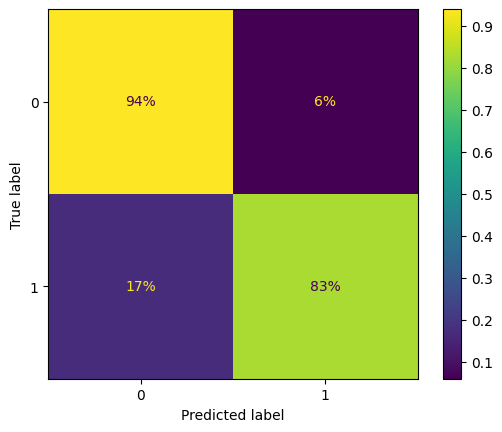

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels, y_pred, normalize="true",
                                        values_format=".0%")
plt.show()